### Import des librairies

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np
from scipy.optimize import curve_fit
import math

### Configuration

In [33]:
df = pd.read_csv("C:\\Users\\gregoire.etot\\Documents\\dev\\ASPE\\LOT_SL.csv", sep=';')
fishTypes = pd.array(["CHA", "GOU", "LOF", "LPP", "VAI"])
colormap = np.array(['skyblue', 'yellow', 'darkkhaki', 'orange', 'purple', 'pink', 'red', 'green'])
n_clusters = 4 # nombre de clusters

### Premier affichage

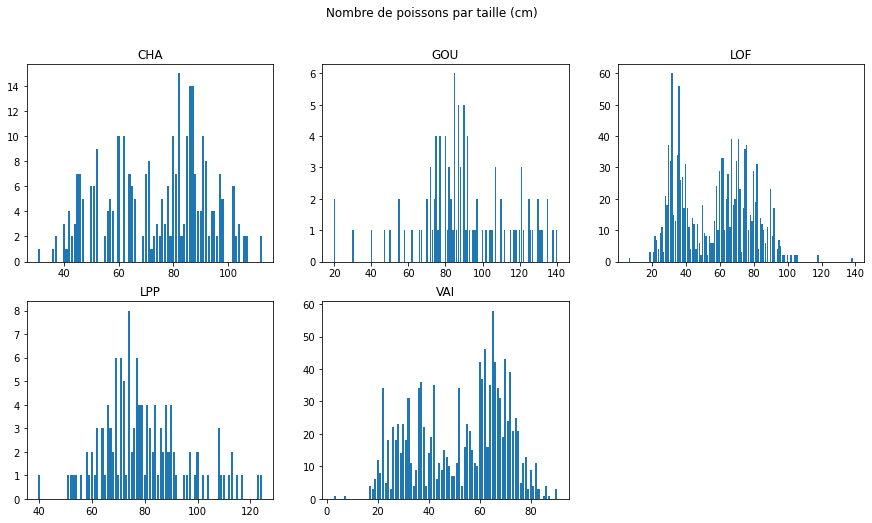

In [34]:
fig, axes = plt.subplots(2,3, figsize=(15,8))
fig.suptitle('Nombre de poissons par taille (cm)')
axesList = fig.get_axes()
axes[1][2].set_visible(False)

for i in range(len(fishTypes)):
    chaDatas = df[df['code_taxon'] == fishTypes[i]]
    sizesCount = chaDatas.groupby("taille_individuelle_reelle_lot_s").size().reset_index(name='counts')
    x = sizesCount["taille_individuelle_reelle_lot_s"]
    y = sizesCount["counts"]
    axesList[i].set_title(fishTypes[i])
    axesList[i].bar(x, y)

### Partitionnement et régression

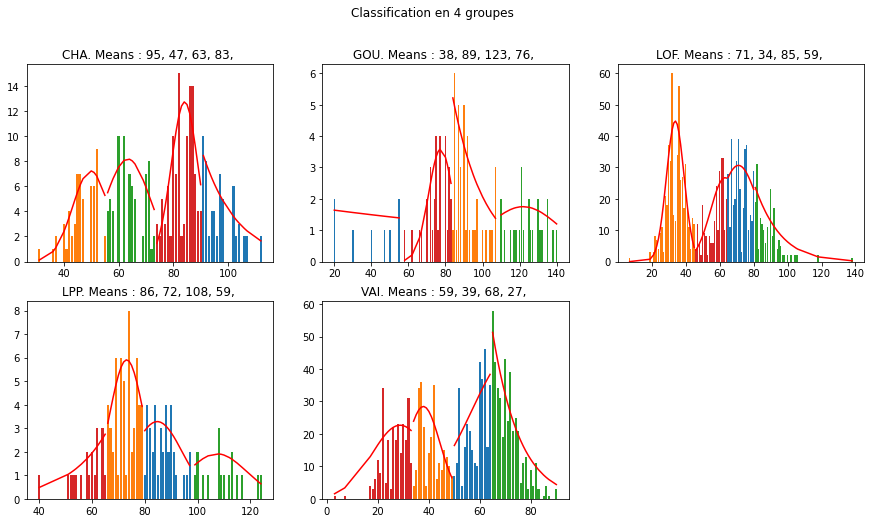

In [35]:
def gauss_function(x, a, x0, sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))
    return a*np.exp(-(np.linalg.norm(x - x0)**2)/(2*sigma**2))

fig, axes = plt.subplots(2,3, figsize=(15,8))
fig.suptitle('Classification en ' + str(n_clusters) + ' groupes')
axesList = fig.get_axes()
axes[1][2].set_visible(False)
    
for i in range(len(fishTypes)):
    chaDatas = df[df['code_taxon'] == fishTypes[i]]
    sizesCount = chaDatas.groupby("taille_individuelle_reelle_lot_s").size().reset_index(name='counts')
    sizes = chaDatas.loc[:,'taille_individuelle_reelle_lot_s'].values
    
    model = KMeans(n_clusters, init = 'k-means++', random_state = 5,  max_iter=1000)
    model.fit(sizes.reshape(-1,1)) 
    
    # reinit index pour permettre la concaténation
    chaDatas.reset_index(level=0, inplace=True)
    # on met le score dans le dataframe
    chaDatasWithLabels = pd.concat((chaDatas, pd.Series(model.labels_).rename('colorlabel')), axis=1)

    chaDatasWithLabels['Count'] = chaDatasWithLabels.groupby(['taille_individuelle_reelle_lot_s'])['colorlabel'].transform('count')

    chaDatasWithLabels = chaDatasWithLabels.sort_values(by=['taille_individuelle_reelle_lot_s'])

    title = fishTypes[i] + ". Means : "
        
    for j in range (0, n_clusters) :
        cluster = chaDatasWithLabels[chaDatasWithLabels['colorlabel'] == j]
        x_cluster = cluster["taille_individuelle_reelle_lot_s"]
        y_cluster = cluster["Count"]

        #mean and standard deviation
        mean = sum(x_cluster * y_cluster)/sum(y_cluster)
        sigma = sum(y_cluster * (x_cluster - mean)**2)/sum(y_cluster)
        sigma = math.sqrt(sigma)

        popt, pcov = curve_fit(gauss_function, x_cluster, y_cluster, p0 = [1, mean, sigma], maxfev=200000)
        #plot the fit results
        title = title + str(int(mean)) + ", "
        axesList[i].set_title(title)
        axesList[i].plot(x_cluster,gauss_function(x_cluster, *popt), c='red')
        #confront with the given data
        axesList[i].bar(x_cluster,y_cluster)
    
    